In [1]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/gonzalo/Downloads/ml4cc-general-access_request_pays.json"
os.environ["GS_USER_PROJECT"] = "ml4cc-general"

In [2]:
from ml4floods.data import utils
from ml4floods.visualization import plot_utils
from ml4floods.data.ee_download import process_metadata
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import matplotlib.pyplot as plt
from math import ceil

path_to_aois = "gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/"
fs = utils.get_filesystem(path_to_aois)

[Flooding period according to Wikipedia](https://en.wikipedia.org/wiki/2022_Eastern_Australia_floods): 23 February 2022 – 7 April 2022

We divide this period in:
* Flooding period first flood 23rd Feb to 27th March
* Flooding period second flood 28th March 10th April

In [3]:
from datetime import datetime, timedelta

flooding_date_pre = "2022-02-20"
flooding_date_pre_dt =datetime.strptime(flooding_date_pre, "%Y-%m-%d")
flooding_date_first_period_start= "2022-02-23"
flooding_date_first_period_end = "2022-03-27"
flooding_date_first_period_start_dt =datetime.strptime(flooding_date_first_period_start, "%Y-%m-%d")
flooding_date_first_period_end_dt =datetime.strptime(flooding_date_first_period_end, "%Y-%m-%d")

flooding_date_second_period_start = "2022-03-28"
flooding_date_second_period_end = "2022-04-10"
flooding_date_second_period_start_dt = datetime.strptime(flooding_date_second_period_start, "%Y-%m-%d")
flooding_date_second_period_end_dt = datetime.strptime(flooding_date_second_period_end, "%Y-%m-%d")

# Plot all the predicted floodmaps for a given Area of Interest

First we grab all the predicted geojsons from the Google Bucket

In [4]:
aoi = "AOI02" # Lismore AoI
# aoi = "QLAOI03" # Cabolture AoI (images out of swath, clouds etc)
# aoi = "QLAOI07"
# aoi = "AUTOAOI144"

aoi_dir = os.path.join(path_to_aois, aoi)

geojsons = [f"gs://{f}" for f in fs.glob(f"{path_to_aois}{aoi}/WF2_unet_rbgiswirs_vec/*/*.geojson")]

# Sort by date (name of the file) and satellite 
def key_sort(x):
    date = os.path.splitext(os.path.basename(x))[0]
    satellite = os.path.basename(os.path.dirname(x))
    # Preference of Sentinel over Landsat
    if satellite == "Landsat":
        append = "B"
    else:
        append = "A"
    return date+append

geojsons.sort(key=key_sort)
geojsons

['gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AOI02/WF2_unet_rbgiswirs_vec/S2/2022-01-30.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AOI02/WF2_unet_rbgiswirs_vec/Landsat/2022-01-30.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AOI02/WF2_unet_rbgiswirs_vec/S2/2022-02-09.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AOI02/WF2_unet_rbgiswirs_vec/S2/2022-03-01.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AOI02/WF2_unet_rbgiswirs_vec/S2/2022-03-11.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AOI02/WF2_unet_rbgiswirs_vec/Landsat/2022-03-11.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AOI02/WF2_unet_rbgiswirs_vec/S2/2022-03-16.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AOI02/WF2_unet_rbgiswirs_vec/Landsat/2022-03-19.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AOI02/WF2_unet_rbgiswirs_vec/S

## Plot mean cloud coverage of available S2 and Landsat images

We have downloaded all images which have less than 60% of clouds

In [5]:
metadata_s2 = process_metadata(f"{path_to_aois}{aoi}/S2/s2info.csv")
metadata_l89 = process_metadata(f"{path_to_aois}{aoi}/Landsat/landsatinfo.csv")

metadata_s2["satellite"] = "S2"
metadata_l89["satellite"] = "Landsat"
metadata = pd.concat([metadata_s2, metadata_l89],ignore_index=True)
metadata.cloud_probability*=100
metadata = metadata[metadata["valids"] >= .8]

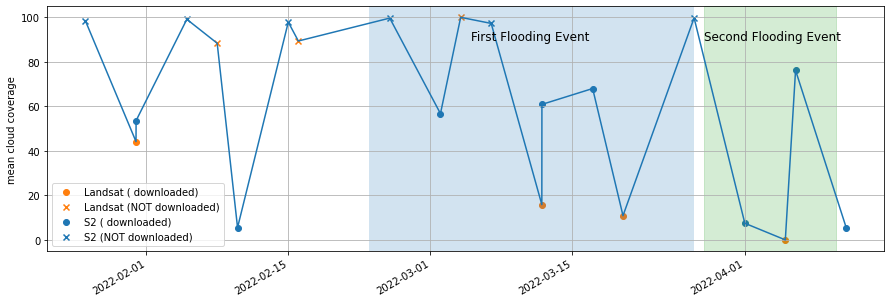

In [6]:

fig, ax = plt.subplots(1,1,figsize=(15,5))

for c,downloaded in product(["Landsat","S2"], [True, False]):
    label=f"{c} ({'' if downloaded else 'NOT'} downloaded)"
    selection_iter = (metadata.satellite == c) & (metadata.s2available == downloaded)
    color = "C0" if c =="S2" else "C1"
    marker = "o" if downloaded else "x"
    ax.scatter(x=metadata[selection_iter].datetime,y=metadata[selection_iter].cloud_probability, 
               label=label,c=color,marker=marker)

ax.legend()
metadata.plot(x="datetime",y="cloud_probability",ax=ax,legend=None)
ax.axvspan(flooding_date_first_period_start_dt, flooding_date_first_period_end_dt, alpha=0.2)
ax.axvspan(flooding_date_second_period_start_dt, flooding_date_second_period_end_dt, alpha=0.2,color="C2")

ax.text(flooding_date_first_period_start_dt + timedelta(days=10), 90, "First Flooding Event", fontsize=12)
ax.text(flooding_date_second_period_start_dt, 90, "Second Flooding Event", fontsize=12)
# for d in [flooding_date_first_period_start, flooding_date_first_period_end,flooding_date_second_period_start,flooding_date_second_period_end]:
#     plt.vlines(x=datetime.strptime(d,"%Y-%m-%d"),ymin=-1,ymax=101,colors="black",linestyles="dashed")
    
plt.ylabel("mean cloud coverage")
plt.xlabel("")
plt.grid()

## Plot Predicted Floodmaps

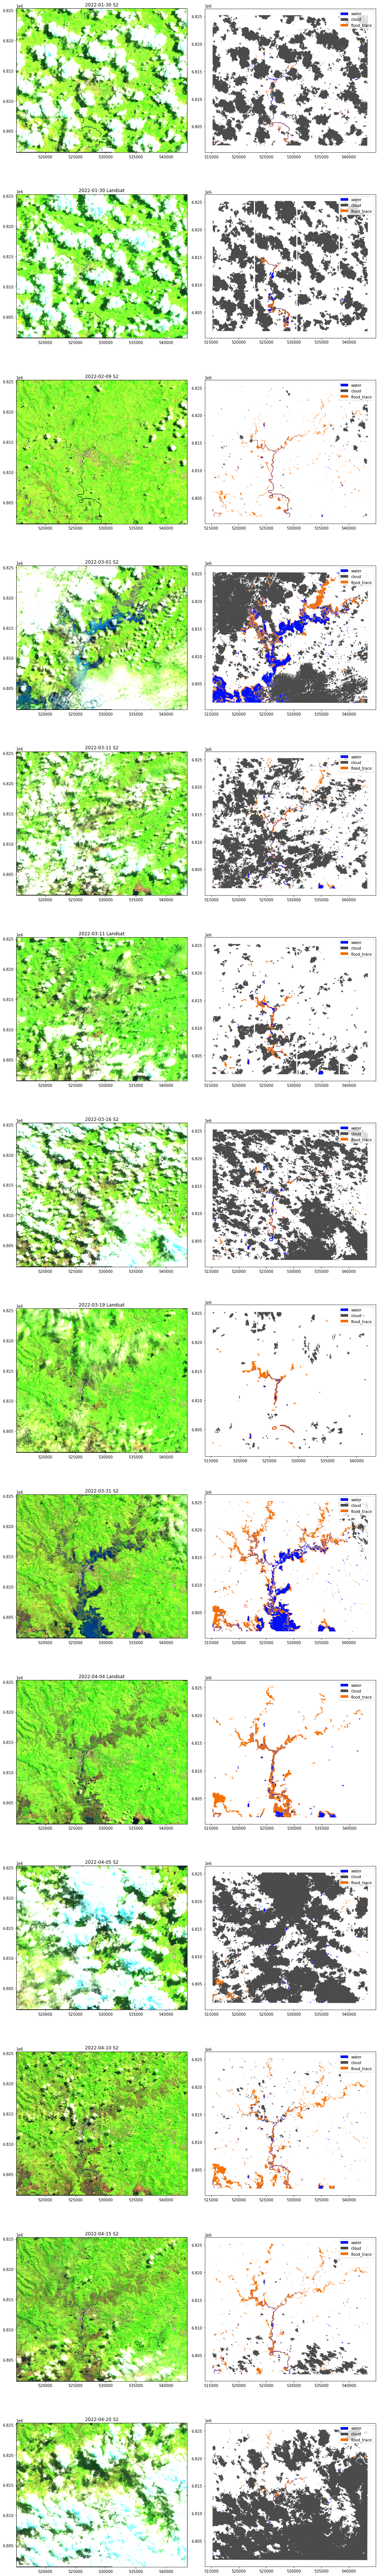

In [7]:
fig, ax =plt.subplots(len(geojsons),2,
                      figsize=(14,len(geojsons)*7),
                      tight_layout=True)

floodmaps = []
for idx,g in enumerate(geojsons):
    date = os.path.splitext(os.path.basename(g))[0]
    satellite_dir = os.path.dirname(g)
    satellite = os.path.basename(satellite_dir)
    aoi_dir = os.path.dirname(os.path.dirname(satellite_dir))
    geotiff = os.path.join(aoi_dir, satellite, f"{date}.tif")
    
    floodmap = utils.read_geojson_from_gcp(g)
    floodmaps.append(floodmap)
    plot_utils.plot_swirnirred_image(geotiff, ax=ax[idx,0], size_read=500, collection_name=satellite)
    plot_utils.plot_floodmap(floodmap, ax=ax[idx,1],legend=True)
    ax[idx,0].set_title(f"{date} {satellite}")

## Plot postflood map

Text(0.5, 1.0, 'Second post flood 2022-03-28 2022-04-10')

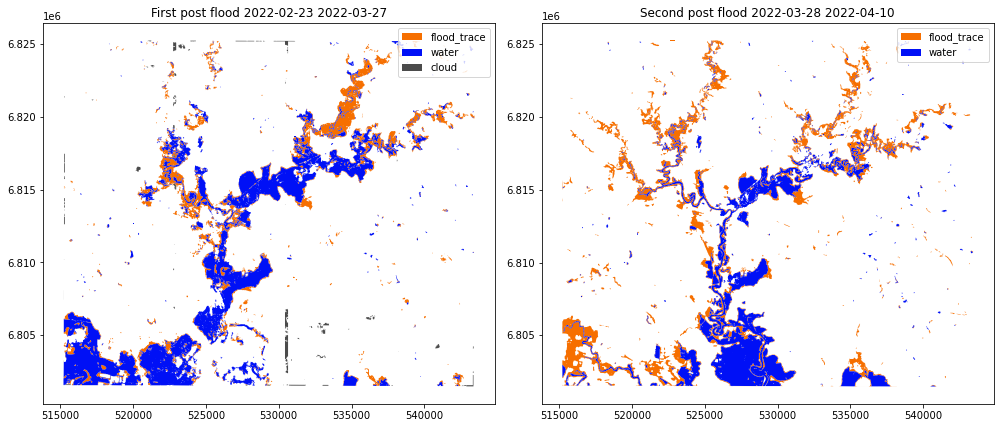

In [8]:
post_flood_path_first_period = os.path.join(aoi_dir, "pre_post_products",
                                            f"postflood_{flooding_date_first_period_start}_{flooding_date_first_period_end}.geojson").replace("\\", "/")

post_flood_path_second_period = os.path.join(aoi_dir, "pre_post_products",
                                             f"postflood_{flooding_date_second_period_start}_{flooding_date_second_period_end}.geojson").replace("\\", "/")

post_flood_path_first_period, post_flood_path_second_period

fig, ax =plt.subplots(1,2,
                      figsize=(14,7),
                      tight_layout=True)

plot_utils.plot_floodmap(post_flood_path_first_period,ax=ax[0])
ax[0].set_title(f"First post flood {flooding_date_first_period_start} {flooding_date_first_period_end}")
plot_utils.plot_floodmap(post_flood_path_second_period,ax=ax[1])
ax[1].set_title(f"Second post flood {flooding_date_second_period_start} {flooding_date_second_period_end}")